In [105]:
# Imports necessary libraries
import torch
import torch.nn.functional as F
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch import nn
import pandas as pd
import pyarrow as pa
from torch.optim import Adam
import numpy as np
import os
import matplotlib.pyplot as plt

In [106]:
# Gets the current working directory so that we can pull some data from locally saved files
current_dir = os.getcwd()

# Saves and manipulates data from files into a dataset fit for the BERT Model

In [107]:
label_files = os.path.join(current_dir, 'labels')
vector_files = os.path.join(current_dir, 'vectors')

label_list = []
vector_list =[]

i = 0
for filename in os.listdir(vector_files):
    file_path = os.path.join(vector_files, filename)
    vector_list.append(torch.load(file_path).detach())
    i+=1
    

j = 0
for filename in os.listdir(label_files):
    if j <= i:
        file_path = os.path.join(label_files, filename)
        label_list.append(torch.load(file_path).detach())
        j+=1
    else:
        break
    
    

In [108]:
# Converts the labels and the bert output for each row into a tensor
labels = torch.cat(label_list).float()
final_pool = torch.cat(vector_list).float()

# Divide all the labels by 4 so that they're in range [0,1]
labels /= 4

# Subtract so that we can better 'bucketize' these values 
labels -= .5

# Organizes each label so that the target value is grouped to either 0 or 1
labels = torch.clip(labels, min=0, max=1)
labels = torch.sign(labels)

# Set up a standard scaler
scaler = StandardScaler()

# Fit the scaler to our data
scaler.fit(final_pool)

# Transform our data using the scaler
normalized_values = scaler.transform(final_pool)

In [109]:
labels[:10]

tensor([1., 1., 0., 0., 1., 1., 0., 1., 1., 1.])

In [110]:
from sklearn.decomposition import PCA

In [111]:
pca = PCA(2)

In [112]:
low_embed = pca.fit_transform(normalized_values)

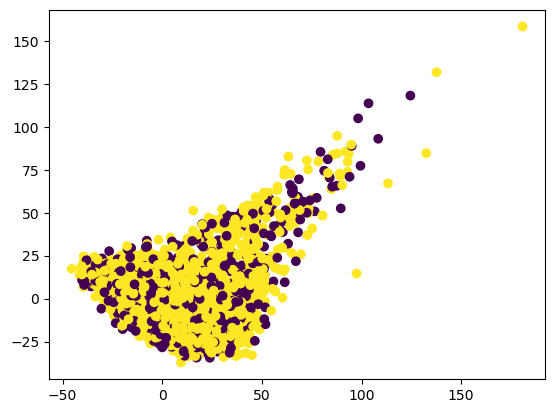

In [113]:
plt.scatter(*low_embed.T, c=labels.numpy())

In [114]:
# Turn our ratings into a tensor
ratings = torch.tensor(labels).float()

/var/folders/45/vvds_7n55h151_y61fjd1fmc0000gn/T/ipykernel_41764/2913663674.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ratings = torch.tensor(labels).float()


In [115]:
# Split up our datasets into test, train and validation sets 
x_train, x_test, y_train, y_test = train_test_split(normalized_values, ratings, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [116]:
# Making Torch datasets with our splits
data = torch.utils.data.TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float())
test_data = torch.utils.data.TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float())
val_data = torch.utils.data.TensorDataset(torch.tensor(x_val).float(), torch.tensor(y_val).float())

/var/folders/45/vvds_7n55h151_y61fjd1fmc0000gn/T/ipykernel_41764/1947057530.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.utils.data.TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float())
/var/folders/45/vvds_7n55h151_y61fjd1fmc0000gn/T/ipykernel_41764/1947057530.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.utils.data.TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float())
/var/folders/45/vvds_7n55h151_y61fjd1fmc0000gn/T/ipykernel_41764/1947057530.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True),

In [117]:
# Set up loaders for each of our datasets 
loader = torch.utils.data.DataLoader(data, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 128, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 128, shuffle = True)

# Defining our model 

In [118]:
# Set up the layers and activation functions of our model
model = torch.nn.Sequential(   
    torch.nn.Linear(768,800),
    torch.nn.SiLU(),
    torch.nn.Linear(800,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,16),
    torch.nn.SiLU(),
    torch.nn.Linear(16,1)
)

In [119]:
# Defines our scoring function
scoring_function = torch.nn.BCEWithLogitsLoss(reduce=False, reduction='none')

# Defines number of epochs we want to train through
num_epochs = 200

# Defines our optimizer and the learning rate 
optimizer = torch.optim.Adam( model.parameters(), .001 )

/Users/stefanfeiler/anaconda3/envs/py4sci/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


# Trains the model on our dataset

In [120]:
def train():  
    
    # Initializes a list that will contain our batch losses for an individual epoch
    epoch_losses = []
    
    # Defines how we want to step through each batch in the epoch
    for batch in loader:
        
        # Resets the grdient to zero
        optimizer.zero_grad()

        # Prepare the input and output tensors for the current batch
        batchX = torch.tensor(batch[0], dtype=torch.float32)
        batchY = torch.tensor(batch[1], dtype=torch.float32)
        batchY = batchY.unsqueeze(1)

        # Forward pass
        y_pred = model.forward(batchX)
        
        # Compute the loss
        loss = scoring_function(y_pred, batchY)
        
        # Store the loss for this batch in the list
        epoch_losses.append(loss)

        # Compute the gradient of the error with respect to the model parameters
        loss.mean().backward()

        # update the model parameters
        optimizer.step()

    
    all_epoch_loss = torch.cat(epoch_losses)
    
    # Returns a list of batch losses for this epoch
    return all_epoch_loss    
        
        
            

In [121]:
# Calls the train function for each of our epochs, prints the running results
for epoch in range(num_epochs):
    ep_result = train()
    print('Epoch {}, Average Error: {}'.format(epoch, ep_result.mean()))

/var/folders/45/vvds_7n55h151_y61fjd1fmc0000gn/T/ipykernel_41764/603159023.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batchX = torch.tensor(batch[0], dtype=torch.float32)
/var/folders/45/vvds_7n55h151_y61fjd1fmc0000gn/T/ipykernel_41764/603159023.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batchY = torch.tensor(batch[1], dtype=torch.float32)


Epoch 0, Average Error: 0.6202512979507446
Epoch 1, Average Error: 0.6066620349884033
Epoch 2, Average Error: 0.605797529220581
Epoch 3, Average Error: 0.6045511960983276
Epoch 4, Average Error: 0.6029741168022156
Epoch 5, Average Error: 0.6000624299049377
Epoch 6, Average Error: 0.6004515886306763
Epoch 7, Average Error: 0.5951228737831116
Epoch 8, Average Error: 0.5863797068595886
Epoch 9, Average Error: 0.5791504383087158
Epoch 10, Average Error: 0.5765911340713501
Epoch 11, Average Error: 0.5648967027664185
Epoch 12, Average Error: 0.5570585131645203
Epoch 13, Average Error: 0.5470231771469116
Epoch 14, Average Error: 0.5418974161148071
Epoch 15, Average Error: 0.5291547775268555
Epoch 16, Average Error: 0.5252296924591064
Epoch 17, Average Error: 0.5237359404563904
Epoch 18, Average Error: 0.5053938627243042
Epoch 19, Average Error: 0.4975408911705017
Epoch 20, Average Error: 0.49139827489852905
Epoch 21, Average Error: 0.4888608455657959
Epoch 22, Average Error: 0.487453281879425

# Tests our model accuracy on our test set

In [130]:
# Defines a function such that each prediction is categorized into either favorable or unfavorable review
def transform_prediction_to_target_format(num):
    if num > 0.5:
        return 1
    else:
        return 0

In [131]:
# Initializes an empty list that will contain the modified predictions (favorable = 1, unfavorable = 0)
itemized_predictions = []

# Set the model to evaluation mode
model.eval()

# Iterate over the test set and collect the model's predictions
predictions = []
for batch in test_loader:
    batch_input_ids = batch[0]
    batch_labels = batch[1]
    
    # Get the raw outputs
    with torch.no_grad():
        outputs = model(batch_input_ids)
    
    # Individually categorizes the predictions
    for output in outputs:
        pred = torch.sigmoid(output)
        itemized_predictions.append(transform_prediction_to_target_format(pred))
        

# Calculate the accuracy on the test set
correct_predictions = 0
for i in range(len(itemized_predictions)):
    if itemized_predictions[i] == y_test[i]:
        correct_predictions += 1

accuracy = correct_predictions / len(y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.599


# Visualizations

In [288]:
first_3_layers = model[:14]
first_3_layers

Sequential(
  (0): Linear(in_features=768, out_features=800, bias=True)
  (1): SiLU()
  (2): Linear(in_features=800, out_features=64, bias=True)
  (3): SiLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): SiLU()
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): SiLU()
  (8): Linear(in_features=64, out_features=64, bias=True)
  (9): SiLU()
  (10): Linear(in_features=64, out_features=64, bias=True)
  (11): SiLU()
  (12): Linear(in_features=64, out_features=16, bias=True)
  (13): SiLU()
)

In [289]:
layer3embeds = first_3_layers(torch.tensor(x_train).float())

In [290]:
layer3embeds.shape

torch.Size([8100, 16])

In [291]:
newPCA = PCA(2)
newScaler = StandardScaler()

In [292]:
pca_of_layer3 = newPCA.fit_transform(newScaler.fit_transform(layer3embeds.detach().numpy()))

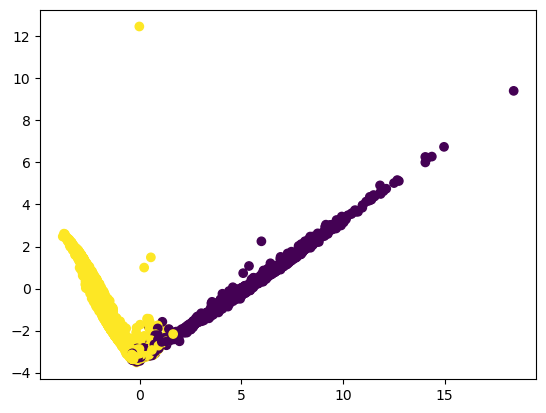

In [293]:
plt.scatter(pca_of_layer3[:, 0], pca_of_layer3[:,1], c=y_train)
#plt.xlim(-5, 60)
#plt.ylim(-20,10)

# Testing our accuracy versus a random trial

In [ ]:
# Calculate the accuracy on the test set
correct_predictions = 0
for i in range(len(itemized_predictions)):
    if itemized_predictions[i] == y_test[i]:
        correct_predictions += 1

In [297]:
# Create a 1000 list of 100 random integers either 0, 1
# Set the size of the array
num_lists = 1000
list_size = len(y_test)

# Generate the random arrays
random_lists = np.random.randint(0, 2, size=(num_lists, list_size))

# Print the first 10 lists
#print(random_lists[:10])

In [300]:
accuracies = []

for li in random_lists:
    correct_guesses = 0
    
    for i in range(len(li)):
        if li[i] == y_test[i]:
            correct_guesses+=1
    accuracies.append(correct_guesses/len(li))
print(np.array(accuracies).mean())
        
        

0.500031


# Saves the model architecture and weights to a file! Hooray!

In [303]:
# Save the model to a file
torch.save(model.state_dict(), "model.pth")